In [9]:
!git clone https://github.com/saic-mdal/lama.git
!pip install -r lama/requirements.txt --quiet

Cloning into 'lama'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 277 (delta 53), reused 255 (delta 42), pack-reused 0
Receiving objects: 100% (277/277), 4.05 MiB | 17.37 MiB/s, done.
Resolving deltas: 100% (53/53), done.
     |████████████████████████████████| 72 kB 588 kB/s 
     |████████████████████████████████| 144 kB 11.5 MB/s 
     |████████████████████████████████| 841 kB 35.2 MB/s 
     |████████████████████████████████| 271 kB 46.0 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
     |████████████████████████████████| 37.1 MB 43 kB/s 
     |████████████████████████████████| 948 kB 40.8 MB/s 
     |████████████████████████████████| 112 kB 49.3 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
     |████████████████████████████████| 269 kB 50.0 MB/s 
     |████████████████████████████████| 176 kB 45.9 MB/s 
     |███████████████████████████████

In [10]:
cd /content/lama

/content/lama


In [11]:
#@title Download a model
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  363M    0  363M    0     0  9841k      0 --:--:--  0:00:37 --:--:-- 10.0M
Archive:  big-lama.zip
  inflating: big-lama/config.yaml    
  inflating: big-lama/models/best.ckpt  


In [12]:
#@title Drawing code
import base64
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
from shutil import copyfile

canvas_html = """
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [13]:
from google.colab import files
files = files.upload()
fname = list(files.keys())[0]

Saving img.png to img.png


In [14]:
#@title Prepare image

! rm -r data_for_prediction
! mkdir data_for_prediction

copyfile(fname, f'./data_for_prediction/{fname}')
fname = f'./data_for_prediction/{fname}'

image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')

plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams["figure.dpi"] = 100
print(f'Will use {fname} for inpainting')
img = np.array(plt.imread(f'{fname}')[:,:,:3])
# _ = plt.imshow(img)
# _ = plt.axis('off')

rm: cannot remove 'data_for_prediction': No such file or directory
Will use ./data_for_prediction/img.png for inpainting


In [19]:
#@title Draw a mask and press Finish 
draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])

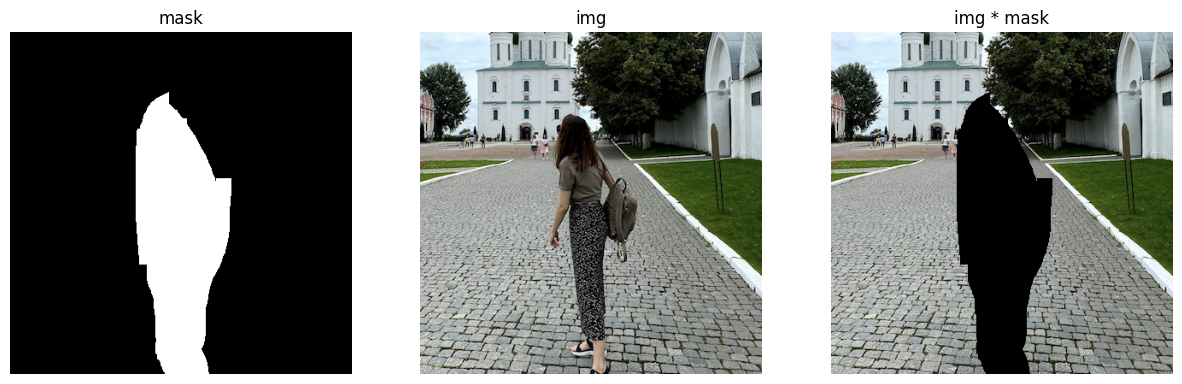

In [20]:
#@title Show a masked image and save a mask
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["figure.dpi"] = 100

plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')
plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray')

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('img * mask')

In [21]:
#@title Run LaMa-inpainting

if '.jpeg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output dataset.img_suffix=.jpeg > /dev/null
elif '.png' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.png > /dev/null
else:
  print('unknown suffix')

100% 1/1 [00:00<00:00,  2.38it/s]


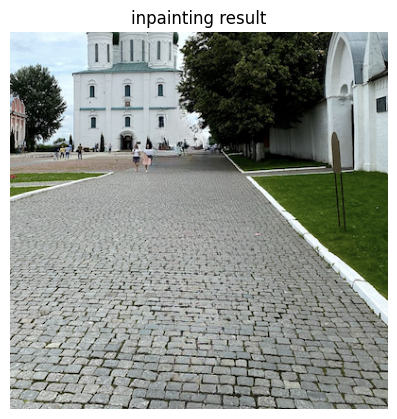

In [22]:
#@title Show the result
plt.imshow(plt.imread(f"/content/output/{fname.split('.')[1].split('/')[2]}_mask.png"))
_=plt.axis('off')
_=plt.title('inpainting result')